In [1]:
import json 
import pandas as pd

with open("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/text_embeddings.json", "r") as f:
    data = json.load(f)

    embeddings = data['embeddings']
    embeddings = {int(key): value for key, value in embeddings.items()}

    text_idxs = data['text_idxs']
    text_idxs = {key: int(value) for key, value in text_idxs.items()} 
    
    pairs_ranking = data['pairs_ranking']
    pairs_ranking = {tuple(json.loads(key)): value for key, value in pairs_ranking.items()}

    pairs = list(pairs_ranking.keys())
    pairs = [(embeddings[pair[0]], embeddings[pair[1]]) for pair in pairs]
    labels = list(pairs_ranking.values())

We have neutral-neutral pairs, and dataset with the hawkish/dovish augmentations.

Then, if doc1 > doc2 (more hawkish) -> doc1.hawkish  > doc2, doc2.dovish., doc1 > doc2.dovish
If doc1 < doc2 (more dovish) -> doc1.dovish < doc2, doc1 < doc2.hawkish, doc1.dovish < doc2.hawkih


In [3]:
import random

qa_df = pd.read_csv("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/qa_data_labeled.csv")

with open("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/train_pairs_ranking.json", "r") as f:
    train_pairs_ranking = json.load(f)
    train_pairs_ranking = {tuple(json.loads(key)): value for key, value in train_pairs_ranking.items()}

with open("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/test_pairs_ranking.json", "r") as f:
    test_pairs_ranking = json.load(f)
    test_pairs_ranking = {tuple(json.loads(key)): value for key, value in test_pairs_ranking.items()}


def generate_pairs_ranking(qa_df, pairs_ranking):
    result_pairs_ranking = {}

    for pair, value in pairs_ranking.items():
        try:
            if value == 1:
                higher_text = pair[0]
                lower_text = pair[1]
            else:
                lower_text = pair[0]
                higher_text = pair[1]
                
            higher_text_date = qa_df.loc[qa_df['text'] == higher_text]['date'].values[0]
            lower_text_date = qa_df.loc[qa_df['text'] == lower_text]['date'].values[0]

            higher_text_hawkish = qa_df.loc[(qa_df['date'] == higher_text_date) & (qa_df['shift'] == 'hawkish')]['text'].values[0]
            higher_text_dovish = qa_df.loc[(qa_df['date'] == higher_text_date) & (qa_df['shift'] == 'dovish')]['text'].values[0]

            lower_text_hawkish = qa_df.loc[(qa_df['date'] == lower_text_date) & (qa_df['shift'] == 'hawkish')]['text'].values[0]
            lower_text_dovish = qa_df.loc[(qa_df['date'] == lower_text_date) & (qa_df['shift'] == 'dovish')]['text'].values[0]


            coinflip = random.random() > 0.5 

            if coinflip:
                #Infered Pairs for higher and lower texts
                result_pairs_ranking[(higher_text_hawkish, lower_text)] =  abs(value)
                result_pairs_ranking[(higher_text, lower_text_dovish)] =  abs(value)
                result_pairs_ranking[(higher_text_hawkish, lower_text_dovish)] =  1

            else:
                result_pairs_ranking[(lower_text, higher_text_hawkish)] =  -1 * abs(value)
                result_pairs_ranking[(lower_text_dovish, higher_text)] =  -1 * abs(value)
                result_pairs_ranking[(lower_text_dovish, higher_text_hawkish)] =  -1

            #Original Pairs from the triplets 
            coinflip = random.random() > 0.5 
            if coinflip:
                result_pairs_ranking[(higher_text_hawkish, higher_text)] =  0.5
                result_pairs_ranking[(higher_text, higher_text_dovish)] =  0.5
                result_pairs_ranking[(higher_text_hawkish, higher_text_dovish)] =  1
            else:
                result_pairs_ranking[(higher_text, higher_text_hawkish)] =  -0.5
                result_pairs_ranking[(higher_text_dovish, higher_text)] =  -0.5
                result_pairs_ranking[(higher_text_dovish, higher_text_hawkish)] =  -1

            coinflip = random.random() > 0.5 
            if coinflip:
                result_pairs_ranking[(lower_text_hawkish, lower_text)] =  0.5
                result_pairs_ranking[(lower_text, lower_text_dovish)] =  0.5
                result_pairs_ranking[(lower_text_hawkish, lower_text_dovish)] =  1
            else:
                result_pairs_ranking[(lower_text, lower_text_hawkish)] =  -0.5
                result_pairs_ranking[(lower_text_dovish, lower_text)] =  -0.5
                result_pairs_ranking[(lower_text_dovish, lower_text_hawkish)] =  -1


        except BaseException as exc: #We dodge exceptions for blocks where some augmentations are missing
            pass 

    return result_pairs_ranking

In [35]:
train_pairs_ranking = generate_pairs_ranking(qa_df, train_pairs_ranking)
test_pairs_ranking = generate_pairs_ranking(qa_df, test_pairs_ranking)

train_pairs_ranking = {json.dumps(key): value for key, value in train_pairs_ranking.items()}
test_pairs_ranking = {json.dumps(key): value for key, value in test_pairs_ranking.items()}

with open("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/train_pairs_ranking_linked.json", "w") as f:
    json.dump(train_pairs_ranking, f)

with open("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/test_pairs_ranking_linked.json", "w") as f:
    json.dump(test_pairs_ranking, f)

In [33]:
len(test_pairs_ranking)

1158

/Users/dzz1th/opt/anaconda3/envs/ucl/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


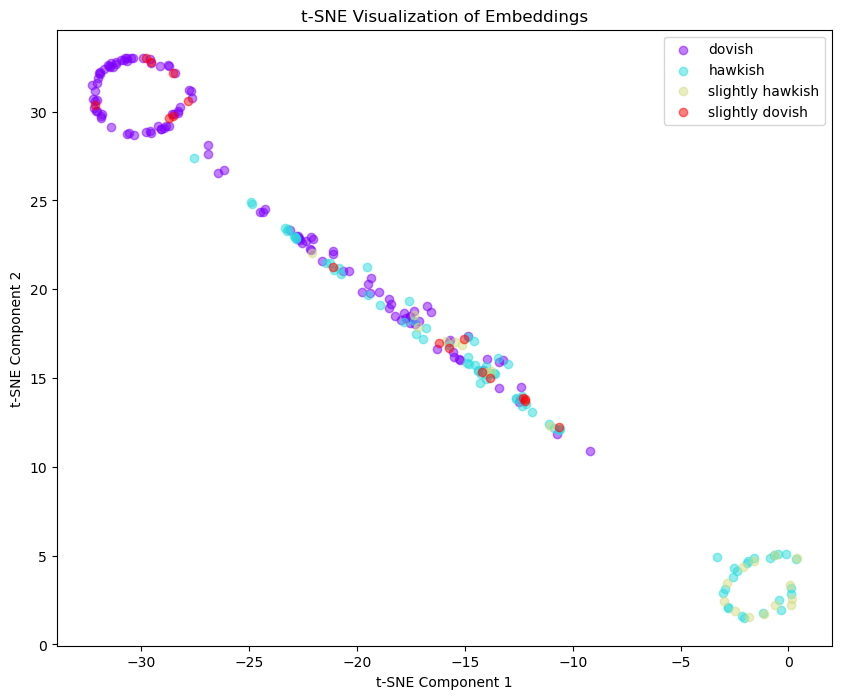

In [46]:
import typing as t
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import umap
qa_df = pd.read_csv("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/qa_data_labeled.csv")
qa_embeddings = np.load("/Users/dzz1th/Job/mgi/Soroka/data/qa_data/qa_embeddings.npy")


# default_indexes = qa_df[qa_df['shift'].isna()].index
# qa_embeddings = qa_embeddings[default_indexes]
# qa_df = qa_df[qa_df['shift'].isna()]

# print(qa_df.head())

def create_time_dimred_plot(qa_df, qa_embeddings, method: t.Literal['tsne', 'umap'] = 'tsne', perplexity=40):
    qa_df = qa_df[qa_df['date'] >= '2020-01-01']
    qa_df['year'] = pd.to_datetime(qa_df['date']).dt.year

    years = sorted(qa_df['year'].unique())
    n_years = len(years)
    colors = plt.cm.rainbow(np.linspace(0, 1, n_years))
    year_color_map = dict(zip(years, colors))

    if method == 'tsne':
        reducer = TSNE(random_state=42, perplexity=perplexity)
    elif method == 'umap':
        reducer = umap.UMAP(random_state=42, n_neighbors=perplexity)
    # Fit and transform the embeddings
    results = reducer.fit_transform(qa_embeddings)

    # Plotting
    plt.figure(figsize=(10, 8))

    for year in years:
        year_mask = qa_df['year'] == year
        year_indices = year_mask.index[year_mask]
        plt.scatter(results[year_indices, 0], results[year_indices, 1], c=year_color_map[year], label=f'Year {year}', alpha=0.5)

    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()

def create_sentiment_dimred_plot(qa_df, qa_embeddings, perplexity=30, method: t.Literal['tsne', 'umap'] = 'tsne'):
    labels = qa_df['label']
    y = [1 if 'hawkish' in label else 0 for label in labels]

    training_embeddings = qa_embeddings[:100]
    training_y = y[:100]

    if method == 'tsne':
        reducer = TSNE(random_state=42, perplexity=perplexity)
        results = reducer.fit_transform(training_embeddings)
    elif method == 'umap':
        reducer = umap.UMAP(random_state=42, n_neighbors=perplexity)
        reducer = reducer.fit(training_embeddings, y=training_y)
        results = reducer.transform(qa_embeddings)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels.unique())))
    label_color_map = dict(zip(labels.unique(), colors))

    plt.figure(figsize=(10, 8))

    for label in labels.unique():
        label_mask = labels == label
        label_indices = label_mask.index[label_mask]
        plt.scatter(results[label_indices, 0], results[label_indices, 1], label=label, color=label_color_map[label], alpha=0.5)

    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()

create_sentiment_dimred_plot(qa_df, qa_embeddings, perplexity=30, method='umap')


In [36]:
qa_df['label'].value_counts()

label
dovish              121
hawkish              77
slightly hawkish     22
slightly dovish      17
Name: count, dtype: int64